In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df  = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Shape of datasets:")
print(f"Train: {train_df.shape} \nTest: {test_df.shape}")

Shape of datasets:
Train: (7613, 5) 
Test: (3263, 4)


In [4]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


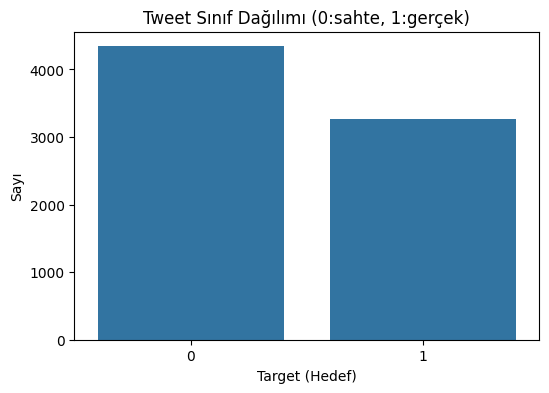

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Tweet Sınıf Dağılımı (0:sahte, 1:gerçek)')
plt.xlabel('Target (Hedef)')
plt.ylabel('Sayı')
print(train_df['target'].value_counts(normalize=True))

plt.show()

We obtained that there is a balance (0.57034|0.42966) between 0s and 1s. There is no problem to train the model with that dataset. Now, we will check if the length of the tweets affects what we looking for that comes from the idea of "people are more likely to write shorter tweets when they are in panic.".

In [6]:
train_df['char_count'] = train_df['text'].apply(len) # number of chars
train_df['word_count']  = train_df['text'].apply(lambda x: len(str(x).split())) # number of words

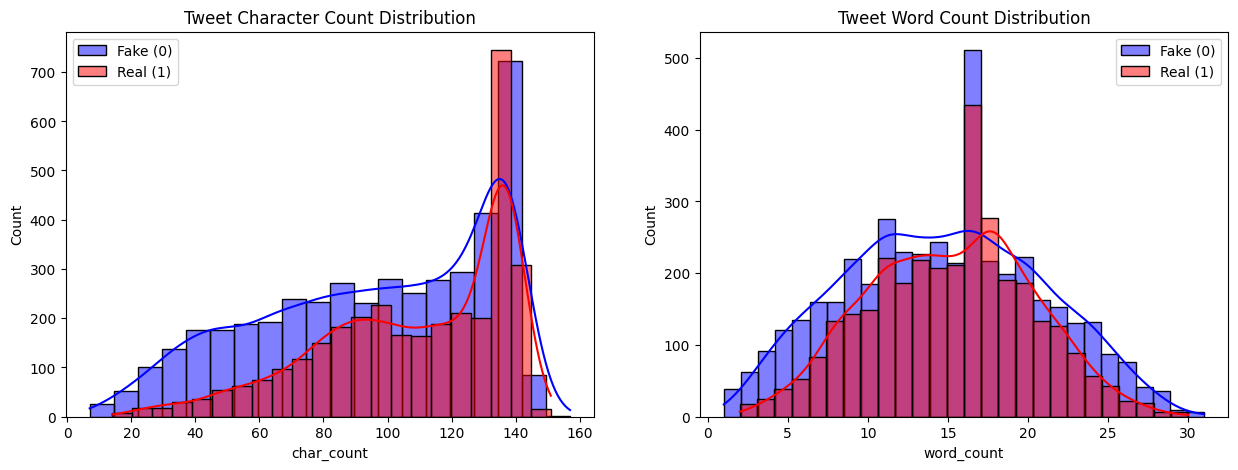

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(train_df[train_df['target']==0]['char_count'], label='Fake (0)', kde=True, color='blue', ax=axes[0])
sns.histplot(train_df[train_df['target']==1]['char_count'], label='Real (1)', kde=True, color='red', ax=axes[0])
axes[0].set_title('Tweet Character Count Distribution')
axes[0].legend()

sns.histplot(train_df[train_df['target']==0]['word_count'], label='Fake (0)', kde=True, color='blue', ax=axes[1])
sns.histplot(train_df[train_df['target']==1]['word_count'], label='Real (1)', kde=True, color='red', ax=axes[1])
axes[1].set_title('Tweet Word Count Distribution')
axes[1].legend()

plt.show()

**The analysis of the distributions reveals that real disaster tweets tend to have higher character and word counts compared to fake ones, suggesting that genuine reports are generally more descriptive. Now, we will check the words that occurs most in real disaster tweets.**

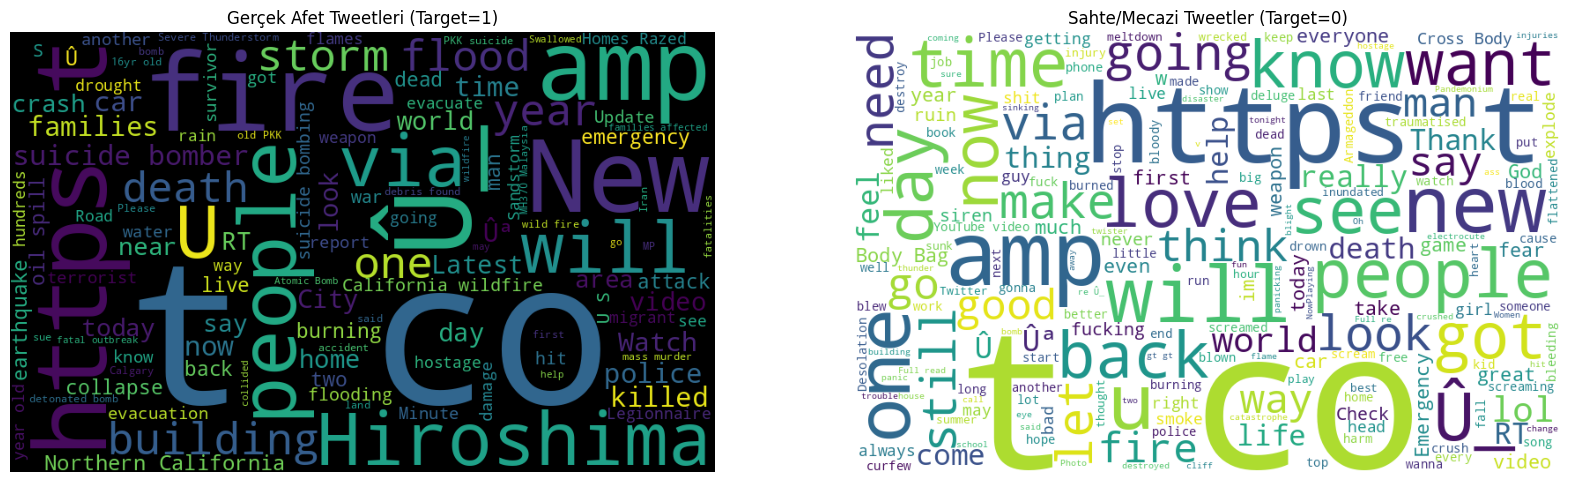

In [8]:
real_tweets = " ".join(train_df[train_df['target'] == 1]['text'])
wordcloud_real = WordCloud(width=800, height=500, background_color='black', min_font_size=10).generate(real_tweets)

fake_tweets = " ".join(train_df[train_df['target'] == 0]['text'])
wordcloud_fake = WordCloud(width=800, height=500, background_color='white', min_font_size=10).generate(fake_tweets)

plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real)
plt.axis("off")
plt.title("Gerçek Afet Tweetleri (Target=1)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.title("Sahte/Mecazi Tweetler (Target=0)")

plt.show()

**Let's clean the texts from stopwords by using NLTK(Natural Language Toolkit).**

In [9]:
import re
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Function that takes the test and clean it step by step.
    """
    
    text = text.lower()
    
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    text = re.sub(r'<.*?>', '', text)
    
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'\w*\d\w*', '', text)
    
    text = [word for word in text.split() if word not in stop_words]
    
    return " ".join(text)

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

print("Cleaning is done!")

print("\n--- Example ---")
print("First version:    ", train_df['text'].iloc[10])
print("Cleaned version:  ", train_df['clean_text'].iloc[10])

Cleaning is done!

--- Example ---
First version:     Three people died from the heat wave so far
Cleaned version:   three people died heat wave far


**Cheking the worldcloud again:**

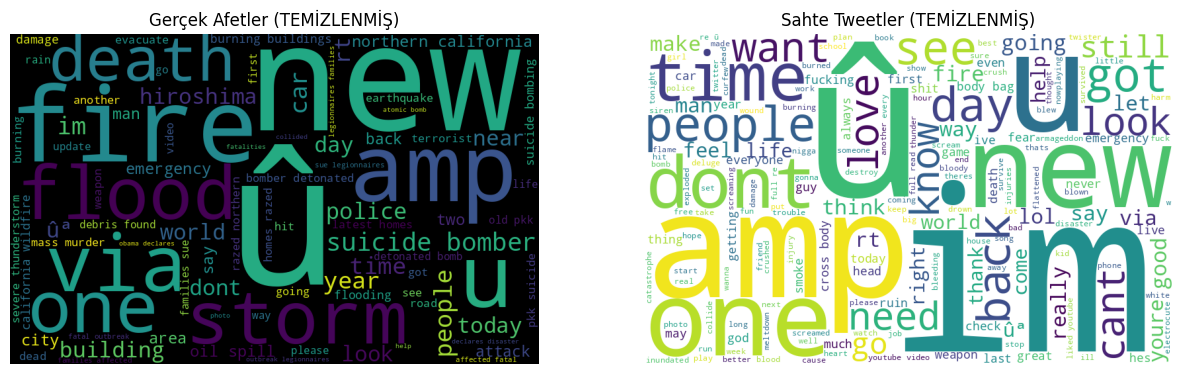

In [10]:
clean_real_tweets = " ".join(train_df[train_df['target'] == 1]['clean_text'])
clean_fake_tweets = " ".join(train_df[train_df['target'] == 0]['clean_text'])

# WordCloud oluştur
wc_real = WordCloud(width=800, height=500, background_color='black', min_font_size=10).generate(clean_real_tweets)
wc_fake = WordCloud(width=800, height=500, background_color='white', min_font_size=10).generate(clean_fake_tweets)

# Çizdir
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_real)
plt.axis("off")
plt.title("Gerçek Afetler (TEMİZLENMİŞ)")

plt.subplot(1, 2, 2)
plt.imshow(wc_fake)
plt.axis("off")
plt.title("Sahte Tweetler (TEMİZLENMİŞ)")

plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("---Baseline Model---")

X = train_df['clean_text']
y = train_df['target']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizing (TF-IDF)

vectorizer = TfidfVectorizer(max_features=5000)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"Matris Scale: {X_train_vec.shape}")

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Test
y_pred = model.predict(X_val_vec)

# Scores
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("-" * 30)
print(f" Accuracy: %{accuracy*100:.2f}")
print(f" F1 Score: %{f1*100:.2f}")
print("-" * 30)
print("\nDetailed Report:\n")
print(classification_report(y_val, y_pred))

---Baseline Model---
Matris Scale: (6090, 5000)
------------------------------
 Accuracy: %79.65
 F1 Score: %74.12
------------------------------

Detailed Report:

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [12]:
!pip install transformers


In [13]:
!pip install transformers

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

print("GPU Durumu:", tf.config.list_physical_devices('GPU'))

2026-02-09 02:26:57.030337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770604017.218589      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770604017.274778      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770604017.716761      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770604017.716834      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770604017.716838      55 computation_placer.cc:177] computation placer alr

GPU Durumu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sample_text = "Real disaster hapening now!.."
encoded = tokenizer(sample_text, padding=True, truncation=True, return_tensors='tf')

print("Orijinal:", sample_text)
print("Token ID'leri:", encoded['input_ids'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Orijinal: Real disaster hapening now!..
Token ID'leri: tf.Tensor([[  101  2613  7071  5292 11837  2075  2085   999  1012  1012   102]], shape=(1, 11), dtype=int32)


I0000 00:00:1770604046.698248      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Starts with 101(CLS), ends with 102(SEP). It's working correctly. Now, we'll write a function to convert all tweets to format BERT can use.


In [15]:
def convert_to_bert_input(texts, labels, max_len=64):
    """
    Converts all texts to tensors for BERT.
    """
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,     
            padding='max_length',    
            truncation=True,   
            return_attention_mask=True,
            return_tensors='tf'       
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])

    return(
        np.array(input_ids),
        np.array(attention_masks)
    ), np.array(labels)

X_train_clean, X_val_clean, y_train, y_val = train_test_split(
    train_df['clean_text'], train_df['target'], test_size=0.2, random_state=42
)

print("Veriler BERT formatına çevriliyor... (Biraz sürebilir)")
(train_input_ids, train_masks), train_labels = convert_to_bert_input(X_train_clean, y_train)
(val_input_ids, val_masks), val_labels = convert_to_bert_input(X_val_clean, y_val)

print(f"Eğitim Seti Hazır: {train_input_ids.shape}")

Veriler BERT formatına çevriliyor... (Biraz sürebilir)
Eğitim Seti Hazır: (6090, 64)


In [16]:
!pip install --upgrade transformers huggingface_hub
# Önce sorunlu sürümü silelim
!pip uninstall -y transformers

# Sonra sağlam sürümü yükleyelim
!pip install transformers==4.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 29.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.1.0 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.
Found existing installation: transformers 5.1.0
Uninstalling transfor

In [24]:
# 1. Mevcut sorunlu kütüphaneleri kaldıralım
!pip uninstall -y tensorflow keras

# 2. Sağlam ve uyumlu versiyonları yükleyelim
!pip install tensorflow==2.15.0 keras==2.15.0 transformers==4.38.2


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [25]:
!pip install -U transformers tf-keras

  Using cached transformers-5.1.0-py3-none-any.whl.metadata (31 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
Using cached transformers-5.1.0-py3-none-any.whl (10.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00a 0:00:01
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.36.2
    Uninstalling huggingface_hub-0.36.2:
     

In [3]:
import os
# Keras uyumluluk modunu açalım (Garanti olsun)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

print(f"TensorFlow Version: {tf.__version__}")
print("🚀 Sistem Başlatılıyor (Safetensors KAPALI)...")

# --- 1. VERİYİ YÜKLE ---
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Basit Temizlik
def simple_clean(text):
    return str(text).lower()

train_df['clean_text'] = train_df['text'].apply(simple_clean)
test_df['clean_text'] = test_df['text'].apply(simple_clean)

# --- 2. BERT TOKENIZER ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def convert_to_bert_input(texts, max_len=64):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_len,
            padding='max_length', truncation=True, return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
    return np.array(input_ids), np.array(attention_masks)

print("Veriler hazırlanıyor... ⏳")
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'], train_df['target'], test_size=0.2, random_state=42)

(train_input_ids, train_masks) = convert_to_bert_input(X_train)
(val_input_ids, val_masks) = convert_to_bert_input(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# --- 3. MODELİ KUR VE EĞİT (Kritik Nokta Burası!) ---
print("\nModel Yükleniyor... 🤖")

# use_safetensors=False diyerek o hatayı veren dosyayı engelliyoruz!
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=2,
    use_safetensors=False  # <--- İŞTE ÇÖZÜM BU!
)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("\n🏋️‍♂️ EĞİTİM BAŞLIYOR...")
history = model.fit(
    [train_input_ids, train_masks], y_train,
    validation_data=([val_input_ids, val_masks], y_val),
    epochs=2, 
    batch_size=32
)

# --- 4. TAHMİN VE DOSYA OLUŞTURMA ---
print("\n📝 Submission Dosyası Hazırlanıyor...")
import numpy as np
import pandas as pd

print("💾 Memory tasarrufu için tahminler parça parça yapılıyor...")

# 1. Hazırlık
test_pred_labels = []
BATCH_SIZE = 32  # GPU'yu yormayacak lokma boyutu
num_samples = len(test_input_ids)

# 2. Döngü ile Tahmin (Manual Batching)
for i in range(0, num_samples, BATCH_SIZE):
    # Veriyi dilimle (Slice)
    batch_ids = test_input_ids[i : i + BATCH_SIZE]
    batch_masks = test_masks[i : i + BATCH_SIZE]
    
    # Modele sor
    output = model([batch_ids, batch_masks], training=False)
    
    # Sonuçları (0 veya 1) al ve listeye ekle
    batch_preds = np.argmax(output.logits, axis=1)
    test_pred_labels.extend(batch_preds)

    # İlerleme durumunu göster (Her 1000 tanede bir)
    if i % 1000 == 0:
        print(f"   İşlenen: {i}/{num_samples} tweet...")

# 3. Dosyayı Kaydet
submission = pd.DataFrame({'id': test_df['id'], 'target': test_pred_labels})
submission.to_csv('submission.csv', index=False)

print("-" * 30)
print(f"🎉 TEBRİKLER! Tüm süreç bitti.")
print(f"✅ 'submission.csv' dosyası hazır. ({len(submission)} satır)")
print("-" * 30)

TensorFlow Version: 2.19.0
🚀 Sistem Başlatılıyor (Safetensors KAPALI)...
Veriler hazırlanıyor... ⏳

Model Yükleniyor... 🤖


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🏋️‍♂️ EĞİTİM BAŞLIYOR...
Epoch 1/2
191/191 [==============================] - 118s 341ms/step - loss: 0.4487 - accuracy: 0.8039 - val_loss: 0.4243 - val_accuracy: 0.8194
Epoch 2/2
191/191 [==============================] - 55s 291ms/step - loss: 0.3335 - accuracy: 0.8654 - val_loss: 0.3961 - val_accuracy: 0.8437

📝 Submission Dosyası Hazırlanıyor...
💾 Memory tasarrufu için tahminler parça parça yapılıyor...
   İşlenen: 0/3263 tweet...
------------------------------
🎉 TEBRİKLER! Tüm süreç bitti.
✅ 'submission.csv' dosyası hazır. (3263 satır)
------------------------------
